# Imports

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import random
import time
import joblib
import os
from utils import get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns, load_run, extract_best_entries, render_single
from IPython.display import display, Image as IPImage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from itertools import repeat
from sklearn.metrics import accuracy_score, classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading + generation

Commented out are a few alternate ways of loading the data.
- Loading all classes, specific classes, or a certain number of classes at random
- Loading all entries in a class, loading a certain number of random entries, loading a certain number of the first entries in a class, or loading a certain number of the most complex entries in a class

In [4]:
load_existing_run = None

if load_existing_run is None:
    # num_cats = 10
    entries_per_cat = 2000
    image_gen_params = {
        'magnification': 4, # Higher values improve antialiasing, but uses more memory during drawing
        'resolution': 32,
        'invert_color': True, # True = white on black
        'stroke_width_scale': 2 # What stroke width to use to trace the lines in the drawing
    }
    
    # files = get_dataset_files()
    # files = random.sample(files, num_cats)
    # names = ['power outlet', 'pickup truck', 'castle']
    names = ['ambulance','bed','bench','bread','castle','cell phone','chair','church','coffee cup','crown','cruise ship','cup','dishwasher','dresser','eye','face',
        'fan','fire hydrant','fish','hammer','hat','helicopter','ice cream','lantern','passport','pickup truck','pillow','power outlet','sailboat','sandwich',
        'snowman','star','strawberry','suitcase','table','telephone','traffic light','watermelon','wine glass']
    files = list(map(lambda n: f"./dataset/{n}.ndjson", names))
    df = extract_best_entries(files, entries_per_cat, recognized=True, skip_first=200)
    # df = extract_random_entries(files, entries_per_cat, recognized=True)
    # df = extract_best_entries(files, entries_per_cat, recognized=True)
    
    print(f'Loaded {len(df)} entries from {files}')
    df = df.sample(len(df))
    print('Done shuffling dataset')
    df = generate_pixel_columns(df, **image_gen_params).reset_index(drop=True)
    print('Done generating pixel columns')

else:
    run = load_run(load_existing_run)
    df = run['data']
    num_cats = len(df['word'].value_counts())
    entries_per_cat = df['word'].value_counts()[df['word'].value_counts().keys()[0]]
    image_gen_params = run['img_params']

Loaded 78000 entries from ['./dataset/ambulance.ndjson', './dataset/bed.ndjson', './dataset/bench.ndjson', './dataset/bread.ndjson', './dataset/castle.ndjson', './dataset/cell phone.ndjson', './dataset/chair.ndjson', './dataset/church.ndjson', './dataset/coffee cup.ndjson', './dataset/crown.ndjson', './dataset/cruise ship.ndjson', './dataset/cup.ndjson', './dataset/dishwasher.ndjson', './dataset/dresser.ndjson', './dataset/eye.ndjson', './dataset/face.ndjson', './dataset/fan.ndjson', './dataset/fire hydrant.ndjson', './dataset/fish.ndjson', './dataset/hammer.ndjson', './dataset/hat.ndjson', './dataset/helicopter.ndjson', './dataset/ice cream.ndjson', './dataset/lantern.ndjson', './dataset/passport.ndjson', './dataset/pickup truck.ndjson', './dataset/pillow.ndjson', './dataset/power outlet.ndjson', './dataset/sailboat.ndjson', './dataset/sandwich.ndjson', './dataset/snowman.ndjson', './dataset/star.ndjson', './dataset/strawberry.ndjson', './dataset/suitcase.ndjson', './dataset/table.ndj

# Data splitting, standardization, and dimensional reduction

In [5]:
train_amt = int(len(df) * .8)

train = df[:train_amt]
test = df[train_amt:]

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

pca_on = True

y = train['word'].to_numpy()
X = train.filter(regex='pixel.+').to_numpy()
print("Done generating features and target")

if pca_on:
    if load_existing_run is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        pca = PCA(.85)
        X = pca.fit_transform(X)
        print(f'PCA & standardization done. Keeping {pca.n_components_} features')
    else:
        scaler = run['scaler']
        pca = run['pca']
        X = scaler.transform(X)
        X = pca.transform(X)
        print('Applied scaler and PCA.')

save_to_disk = True

if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    with open(folder + 'img_params', 'w') as f:
        f.writelines(str(image_gen_params))
    print('Done saving dataset to disk')
    if pca_on:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(scaler, folder + 'scaler')
        print('Done saving PCA and scaler to disk')

Train: 62400 entries, test: 15600 entries.
Done generating features and target
PCA & standardization done. Keeping 180 features
Done saving dataset to disk
Done saving PCA and scaler to disk


# Model training

In [19]:
classifiers = {
    # 'LinearSVC': LinearSVC(dual=False),
    # 'NuSVC': NuSVC(nu=1e-07, tol=1e-09),
    # 'SGDClassifier': SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1),
    # 'SVC': SVC(kernel='rbf', C=2.5, gamma=.0001105),
    # 'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(store_covariance=True, tol=1e-06),
    # 'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(store_covariance=True, tol=1e-06),
    # 'MLPClassifier': MLPClassifier(hidden_layer_sizes=tuple(repeat(int(pca.n_components_ * 1.2), 3)), solver='lbfgs', alpha=1e-07),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
    # 'ExtraTreeClassifier': ExtraTreeClassifier(),
    # 'KernelRidge': KernelRidge(),
    # 'GaussianProcess': GaussianProcessClassifier(1.0 * RBF(1.0)),
    'LinearRegression': LogisticRegression(dual=False, max_iter=10000, C=.01, tol=1e-07)
}

models = {}
for type, classifier in classifiers.items():
    start = time.time()
    models[type] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    end = time.time()
    print(f"Done training {type} model in {'{:.2f}'.format(end - start)}s")

if save_to_disk:
    joblib.dump(models, folder + 'models')
    print("Done saving models to disk")

Done training LinearRegression model in 19.22s
Done saving models to disk


# Model evaluation

In [20]:
print('Random chance: ' + '{:.2f}%'.format(100 / len(names)))

for model_type, model in models.items():
    test2 = test.filter(regex='pixel.+').to_numpy()
    if pca_on:
        test2 = scaler.transform(test2)
        test2 = pca.transform(test2)
    prediction = model.predict(test2)

    truth = test['word'].values.tolist()
    acc_score = accuracy_score(truth, prediction)
    print(f"{model_type} classifier, accuracy: {'{:.2f}%'.format(acc_score * 100)}")
    print(classification_report(truth, prediction, zero_division=0))

Random chance: 2.56%
LinearRegression classifier, accuracy: 42.02%
               precision    recall  f1-score   support

    ambulance       0.36      0.37      0.36       374
          bed       0.27      0.19      0.22       403
        bench       0.50      0.68      0.57       366
        bread       0.15      0.05      0.07       439
       castle       0.24      0.20      0.22       409
   cell phone       0.37      0.48      0.42       401
        chair       0.54      0.71      0.62       420
       church       0.37      0.27      0.31       441
   coffee cup       0.39      0.47      0.42       386
        crown       0.37      0.31      0.34       405
  cruise ship       0.22      0.19      0.20       396
          cup       0.32      0.21      0.25       413
   dishwasher       0.50      0.56      0.53       380
      dresser       0.35      0.25      0.30       406
          eye       0.41      0.56      0.48       405
         face       0.53      0.61      0.57       4

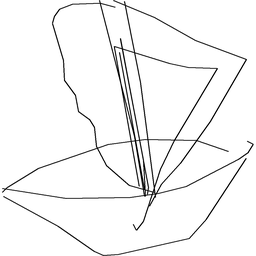

Using MLPClassifier classifier
passport(predicted) == sailboat(actual) ? False


In [32]:
# cls_type, model = random.choice(list(models.items()))
# cls_type = 'MLPClassifier'
model = models[list(models.keys())[0]]

sample = test.sample(1)
sample_predict = sample.filter(regex='pixel.+').to_numpy()

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(f"Using {cls_type} classifier")
print(f"{prediction[0]}(predicted) == {sample['word'].iloc[0]}(actual) ? {sample['word'].iloc[0] == prediction[0]}")